# Assignment 3

Author: Emilie Berg (ncb427)

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

In [2]:
data = np.genfromtxt("mars_soil.txt")  # import data

v = data[:,0]  # velocity data in mm/s
counts = data[:,1]  # counts of velocity data
dcounts = 0.03 * 1e4  # uncertainty on counts

C_d = np.identity(512) * dcounts**2  # data covariance matrix (assuming independent measurements)

print(f"The number of data-points is: {len(v)}")

The number of data-points is: 512


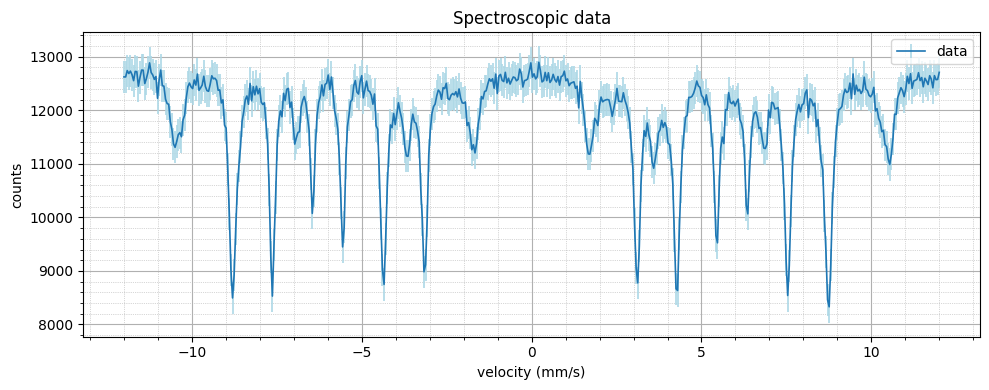

In [3]:
# I start by plotting the data (dark blue is data points and light blue is uncertainty)
plt.figure(figsize=(10,4))
plt.errorbar(v, counts, fmt="-", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="data")
plt.grid(which='major', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.ylabel("counts")
plt.xlabel("velocity (mm/s)")
plt.title("Spectroscopic data")
plt.legend()
plt.tight_layout()

### Problem 1

First, I assume that the peaks are Gaussian. Then I have the non-linear relation

$$d_i = \Sigma_{j=1}^{q} \frac{A_j}{(2 \pi)^{1/2}c_j} \exp(-\frac{(z_i-f_j)^2}{2c_j^2})$$

The partial derivatives of this with respect to each of the model parameters can be computed analytically as

$$\frac{\partial g_i}{\partial A_p} = \frac{1}{(2 \pi)^{1/2} c_p} \exp(-\frac{(z_i-f_p)^2}{2c_p^2}),$$

$$\frac{\partial g_i}{\partial f_p} = \frac{A_p(z_i-f_p)}{c_p^3(2 \pi)^{1/2}} \exp(-\frac{(z_i-f_p)^2}{2c_p^2}),$$

$$\frac{\partial g_i}{\partial c_p} = (\frac{A_p(z_i-f_p)^2}{c_p^2 (2 \pi)^{1/2}} -\frac{A_p}{c_p^2 (2 \pi)^{1/2}}) \exp(-\frac{(z_i-f_p)^2}{2c_p^2}).$$

### Problem 2

Next, I assume that the peaks are Lorentzian. In this case, I have the non-linear relation

$$d_i = \Sigma_{j=1}^{q} \frac{A_j c_j^2}{(z_i - f_j)^2 + c_j^2}.$$

For this relation, the partial derivatives can also be computed analytically. This yields

$$\frac{\partial g_i}{\partial A_p} = \frac{c_p^2}{(z_i-f_p)^2+c_p^2},$$

$$\frac{\partial g_i}{\partial f_p} = \frac{2A_pc_p^2(z_i-f_p)}{((z_i-f_p)^2 + c_p^2)^2},$$

$$\frac{\partial g_i}{\partial c_p} = \frac{2A_pc_p}{(z_i-f_p)^2 + c_p^2} - \frac{2A_pc_p^3}{((z_i-f_p)^2 + c_p^2)^2}.$$

### Problem 3

Now I am going to define functions in my program to evaluate the derivatives.

In [4]:
def differentiate(F, PAR):
    """This function differentiates the function F with respect to the given parameters PAR."""

    diff_list = []  # initialize list for partial derivatives

    for i in range(len(PAR)):
        diff_i = F.diff(PAR[i])  # differentiate F with respect to parameter number i
        diff_list.append(diff_i)  # save partial derivative in list

    return diff_list

In [5]:
A_sym, f_sym, c_sym, z_sym = symbols("A, f, c, z")  # define symbols for Sympy

par = np.array([A_sym, f_sym, c_sym])  # define array of parameters to differentiate with respect to

In [6]:
# First I assume Gaussian peaks

g_gauss = A_sym / ((2*np.pi)**(1/2) * c_sym) * exp(-((z_sym-f_sym)**2)/(2*c_sym**2))  # define expression of relation assuming Gaussian peaks (without the sum)

diff_g_gauss = differentiate(g_gauss, par)  # compute partial derivatives

# save each of the derivatives separately
dgdA_gauss = diff_g_gauss[0]
dgdf_gauss = diff_g_gauss[1]
dgdc_gauss = diff_g_gauss[2]

# turn the expressions of the derivatives into functions
f_dgdA_gauss = lambdify((A_sym, f_sym, c_sym, z_sym), dgdA_gauss)
f_dgdf_gauss = lambdify((A_sym, f_sym, c_sym, z_sym), dgdf_gauss)
f_dgdc_gauss = lambdify((A_sym, f_sym, c_sym, z_sym), dgdc_gauss)

# vectorize functions
f_dgdA_gauss = np.vectorize(f_dgdA_gauss)
f_dgdf_gauss = np.vectorize(f_dgdf_gauss)
f_dgdc_gauss = np.vectorize(f_dgdc_gauss)

In [7]:
# Then I assume Lorentzian peaks

g_lorentz = (A_sym * c_sym**2) / ((z_sym-f_sym)**2 + c_sym**2)  # define expression of relation assuming Lorentzian peaks (without the sum)

diff_g_lorentz = differentiate(g_lorentz, par)  # compute partial derivatives

# save each of the derivatives separately
dgdA_lorentz = diff_g_lorentz[0]
dgdf_lorentz = diff_g_lorentz[1]
dgdc_lorentz = diff_g_lorentz[2]

# turn the expressions of the derivatives into functions
f_dgdA_lorentz = lambdify((A_sym, f_sym, c_sym, z_sym), dgdA_lorentz)
f_dgdf_lorentz = lambdify((A_sym, f_sym, c_sym, z_sym), dgdf_lorentz)
f_dgdc_lorentz = lambdify((A_sym, f_sym, c_sym, z_sym), dgdc_lorentz)

# vectorize functions
f_dgdA_lorentz = np.vectorize(f_dgdA_lorentz)
f_dgdf_lorentz = np.vectorize(f_dgdf_lorentz)
f_dgdc_lorentz = np.vectorize(f_dgdc_lorentz)

The next step is to determine my initial guesses of the model parameters $m_0$ and the model covariance matrix $C_m$. I find these through visual inspection of the data. In order to check that my initial guesses are reasonable, I plot the solution given my initial guesses on top of the data for comparison. Therefore, I start by defining a function to evaluate the solution $g(m)$ given model parameters for both Gaussian and Lorentzian peaks.

In [8]:
def f_g_gauss(z, A, f, c):
    g = A[:, np.newaxis] / ((2*np.pi)**(1/2) * c[:, np.newaxis]) * np.exp(-((z[np.newaxis, :]-f[:, np.newaxis])**2)/(2*c[:, np.newaxis]**2))
    return np.sum(g, axis=0) + 12623


def f_g_lorentz(z, A, f, c):
    g = (A[:, np.newaxis] * c[:, np.newaxis]**2) / ((z[np.newaxis, :]-f[:, np.newaxis])**2 + c[:, np.newaxis]**2)
    return np.sum(g, axis=0) + 12623

Now I can determine my initial guesses $m_0$. First I do it for the Gaussian case.

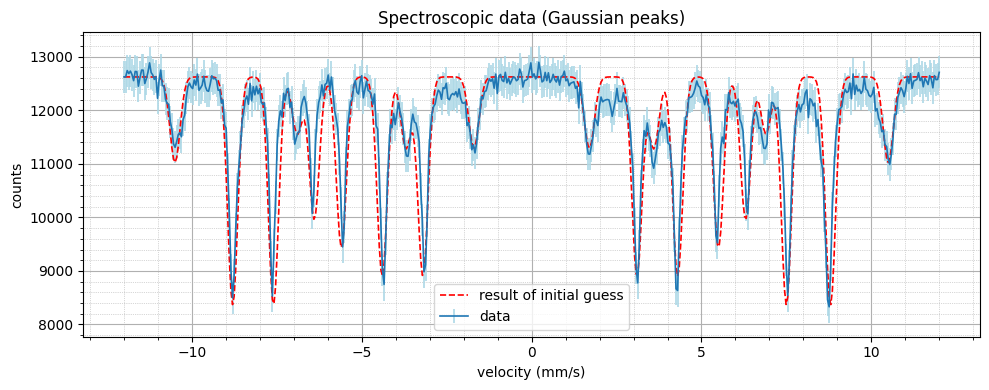

In [9]:
# initial guess of peak locations
f0_gauss = np.array([-10.5, -8.8, -7.6, -6.9, -6.4, -5.6, -4.4, -3.7, -3.2, -1.7, 1.7, 3.1, 3.6, 4.3, 5.5, 6.3, 6.9, 7.5, 8.8, 10.5])

# initial guess of widths
# I notice that each of the peaks have approximately the same width (around 0.15 mm/s) when assuming Gaussian peaks
c0_gauss = 0.15 * np.ones(20)

# I approximate the peaks as triangles to find the areas
# Reading off the plot yields the following
A0_gauss = - 1/2 * 1000/5 * np.array([6, 16, 16, 4, 10, 12, 14, 5, 14, 5, 5, 14, 5, 14, 12, 10, 4, 16, 16, 6])
# I have set the areas negative since the peaks point downward


# I plot my initial guess and the data
g_guess_gauss = f_g_gauss(v, A0_gauss, f0_gauss, c0_gauss)

plt.figure(figsize=(10,4))
plt.errorbar(v, counts, fmt="-", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="data")
plt.plot(v, g_guess_gauss, "r--", linewidth=1.2, label="result of initial guess")
plt.grid(which='major', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.ylabel("counts")
plt.xlabel("velocity (mm/s)")
plt.title("Spectroscopic data (Gaussian peaks)")
plt.legend()
plt.tight_layout()

Looking at the plot, I assume that the uncertainty on the initial estimate of $f$ compared to the actual location of the peak is $\sigma_{f_0} = 0.2$. Likewise, I assume that the uncertainty on the initial estimate of the width $c$ compared to the true value is $\sigma_{c_0} = 0.2$. And I estimate that the uncertainty on the initial estimate of the area $A$ compared to the true area is $\sigma_{A_0} = 0.3 * A_0$. Furthermore, I assume that each of the model parameters are uncorrelated meaning that there should only be non-zero entries on the diagonal of the covariance matrix. Now I can construct the covariance matrix.

In [10]:
# define uncertainties on the prior information on the data
sigma_A0_gauss = 0.3 * np.abs(A0_gauss)
sigma_f0_gauss = 0.2 * np.ones(len(f0_gauss))
sigma_c0_gauss = 0.2 * np.ones(len(c0_gauss))

# combine uncertainties for all parameters in a single vector
sigma_m0_gauss = np.column_stack((sigma_A0_gauss, sigma_f0_gauss, sigma_c0_gauss)).flatten()

# construct covariance matrix
C_m_gauss = np.identity(60) * sigma_m0_gauss**2

Now I redo this assuming Lorentzian peaks.

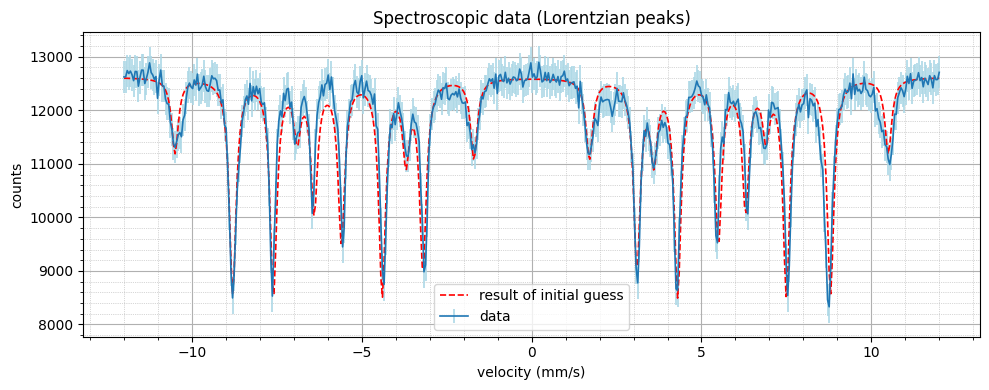

In [11]:
# initial guess of f
f0_lorentz = np.array([-10.5, -8.8, -7.6, -6.9, -6.4, -5.6, -4.4, -3.7, -3.2, -1.7, 1.7, 3.1, 3.6, 4.3, 5.5, 6.3, 6.9, 7.5, 8.8, 10.5])

# initial guess of c
c0_lorentz = 0.12 * np.ones(20)  

# initial guess of A
A0_lorentz = - 1/2 * 1000/5 * np.array([14, 40, 40, 10, 24, 30, 40, 14, 35, 15, 15, 35, 14, 40, 30, 24, 10, 40, 40, 14])


# I plot my initial guess and the data
g_guess_lorentz = f_g_lorentz(v, A0_lorentz, f0_lorentz, c0_lorentz)

plt.figure(figsize=(10,4))
plt.errorbar(v, counts, fmt="-", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="data")
plt.plot(v, g_guess_lorentz, "r--", linewidth=1.2, label="result of initial guess")
plt.grid(which='major', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.ylabel("counts")
plt.xlabel("velocity (mm/s)")
plt.title("Spectroscopic data (Lorentzian peaks)")
plt.legend()
plt.tight_layout()

Looking at the plot, I estimate $\sigma_{A_0} = 0.3 * A_0$, $\sigma_{f_0} = 0.2$ and $\sigma_{c_0} = 0.2$. Again, I assume that the model parameters are uncorrelated. I collect this information in the model covariance matrix.

In [12]:
# define uncertainties on the prior information on the data
sigma_A0_lorentz = 0.3 * np.abs(A0_gauss)
sigma_f0_lorentz = 0.2 * np.ones(len(f0_gauss))
sigma_c0_lorentz = 0.2 * np.ones(len(c0_gauss))

# combine uncertainties for all parameters in a single vector
sigma_m0_lorentz = np.column_stack((sigma_A0_lorentz, sigma_f0_lorentz, sigma_c0_lorentz)).flatten()

# construct covariance matrix
C_m_lorentz = np.identity(60) * sigma_m0_lorentz**2

Next, I define functions to compute the matrix $G$ of partial derivatives. Since I have found 20 peaks and there are 3 model parameters for each peak, I have 60 model parameters in total. Hence, the matrix G is going to have 60 columns and 512 rows (since there are 512 data points).

In [13]:
def G_gauss(A, f, c, z):
    """This function computes the matrix G assuming Gaussian peaks."""

    N = len(v)  # set number of rows
    M = 60  # set number of columns

    G_matrix = np.zeros((N, M))  # initialize matrix G

    # evaluate the partial derivatives with respect to each model parameter for each data point
    for i in range(N):
        G_row = np.column_stack((f_dgdA_gauss(A, f, c, np.ones(20)*z[i]), f_dgdf_gauss(A, f, c, np.ones(20)*z[i]), f_dgdc_gauss(A, f, c, np.ones(20)*z[i]))).flatten()  # compute row number i of G
        G_matrix[i, :] = G_row  # save the computed row in the matrix

    return G_matrix


def G_lorentz(A, f, c, z):
    """This function computes the matrix G assuming Lorentzian peaks."""
    N = len(v)  # set number of rows
    M = 60  # set number of columns

    G_matrix = np.zeros((N, M))  # initialize matrix G

    # evaluate the partial derivatives with respect to each model parameter for each data point
    for i in range(N):
        G_row = np.column_stack((f_dgdA_lorentz(A, f, c, np.ones(20)*z[i]), f_dgdf_lorentz(A, f, c, np.ones(20)*z[i]), f_dgdc_lorentz(A, f, c, np.ones(20)*z[i]))).flatten()   # compute row number i of G
        G_matrix[i, :] = G_row  # save the computed row in the matrix

    return G_matrix

Now I can use these to evaluate the derivatives at the trial solution (the initial guess).

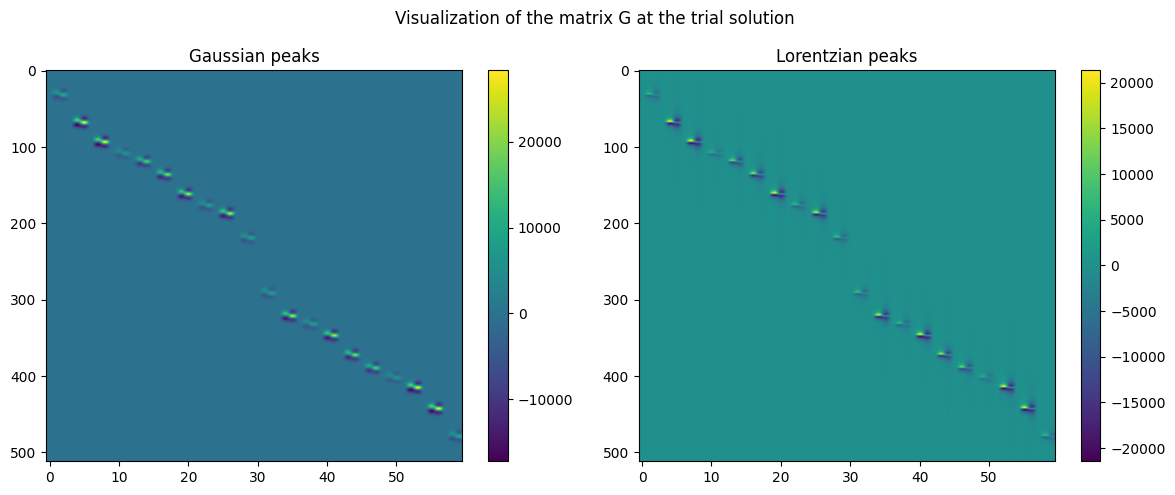

In [14]:
G0_gauss = G_gauss(A0_gauss, f0_gauss, c0_gauss, v)  # derivatives at trial solution assuming Gaussian peaks
G0_lorentz = G_lorentz(A0_lorentz, f0_lorentz, c0_lorentz, v)  # derivatives at trial solution assuming Lorentzian peaks

# I visualize the derivatives at the trial solution
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

imG0_gauss = ax[0].imshow(G0_gauss, aspect="auto")
cbar1 = fig.colorbar(imG0_gauss, ax=ax[0])
ax[0].set_title("Gaussian peaks")

imG0_lorentz = ax[1].imshow(G0_lorentz, aspect="auto")
cbar2 = fig.colorbar(imG0_lorentz, ax=ax[1])
ax[1].set_title("Lorentzian peaks")

plt.suptitle("Visualization of the matrix G at the trial solution")
fig.tight_layout()

I see that there are only non-zero entries in small "clusters" approximately along the diagonal. This is also what I expected, since each "cluster" projected onto the vertical axis corresponds to a peak being present (giving rise to discrete groups of non-zero partial derivatives), and each "cluster" projected onto the horizontal axis corresponds to the dependence of this peak on the different model parameters. And naturally I only expect a specific peak to depend on its own model parameters which would give rise to the approximately diagonal structure seen in the matrices.

Now I am going to implement the steepest descent algorithm and use it to find acceptable estimates of the model parameters. I start by defining a function that can perform the steepest descent method assuming either Gaussian or Lorentzian peaks. I terminate the iterations when the solution "fits the observed data within their uncertainty", hence when

$$\lVert{d_{obs} - g(m_{est})}\rVert^2 < N \sigma^2,$$

where $N$ is the number of data points and $\sigma$ is the uncertainty on a single data point. Furthermore, in each step of the algorithm, I compute the optimal value for $\varepsilon$ given in the footnote on page 72 in the notes

$$\varepsilon_k = \frac{\gamma_k^T C_M^{-1} \gamma_k}{\gamma_k^T (G_k^T C_D^{-1} G_k + C_M^{-1}) \gamma_k},$$

where $\gamma_k$ is the direction of steepest ascent at the $k$'th iteration.

In [15]:
def steepest_descent(z, d_obs, A_ini, f_ini, c_ini, type):
    """This function fits the model parameters to the data using the steepest descent method."""

    # initialize model parameters as initial guesses
    A = np.copy(A_ini)
    f = np.copy(f_ini)
    c = np.copy(c_ini)

    m0 = np.column_stack((A, f, c)).flatten()  # collect all initial model parameters in a single vector
    m = np.copy(m0)  # initialize the vector of model parameters as the initial guesses

    # if Gaussian peaks are assumed, use the model covariance matrix and forward relation for Gaussian peaks
    if type == "gauss":
        C_m = C_m_gauss
        g = f_g_gauss(z, A, f, c)
    
    # if Lorentzian peaks are assumed, use the model covariance matrix and forward relation for Lorentzian peaks
    elif type == "lorentz":
        C_m = C_m_lorentz
        g = f_g_lorentz(z, A, f, c)

    while np.linalg.norm(counts-g)**2 >= len(v)*dcounts**2:  # iterate until the model solution fits the data within their uncertainty
        
        # if Gaussian peaks are assumed, use forward relation for Gaussian peaks
        if type == "gauss":
            g = f_g_gauss(z, A, f, c)
            G = G_gauss(A, f, c, z)
        
        # if Lorentzian peaks are assumed, use forward relation for Lorentzian peaks
        elif type == "lorentz":
            g = f_g_lorentz(z, A, f, c)
            G = G_lorentz(A, f, c, z)

        # compute direction of steepest ascent
        gamma = C_m @ G.T @ np.linalg.inv(C_d) @ (g - d_obs) + (m - m0)
        
        # compute optimal value for epsilon for the current iteration
        epsilon = (gamma.T @ np.linalg.inv(C_m) @ gamma) / (gamma.T @ (G.T @ np.linalg.inv(C_d) @ G + np.linalg.inv(C_m)) @ gamma)

        # take a step in the direction of steepest descent
        m = m - epsilon * gamma

        # extract parameter values from vector m
        m_reshaped = m.reshape((20,3))
        A, f, c = m_reshaped[:, 0], m_reshaped[:, 1], m_reshaped[:, 2]
    
    return A, f, c

Now I perform the steepest descent method assuming Gaussian and Lorentzian peaks.

In [16]:
A_gauss, f_gauss, c_gauss = steepest_descent(v, counts, A0_gauss, f0_gauss, c0_gauss, type="gauss")
A_lorentz, f_lorentz, c_lorentz = steepest_descent(v, counts, A0_lorentz, f0_lorentz, c0_lorentz, type="lorentz")


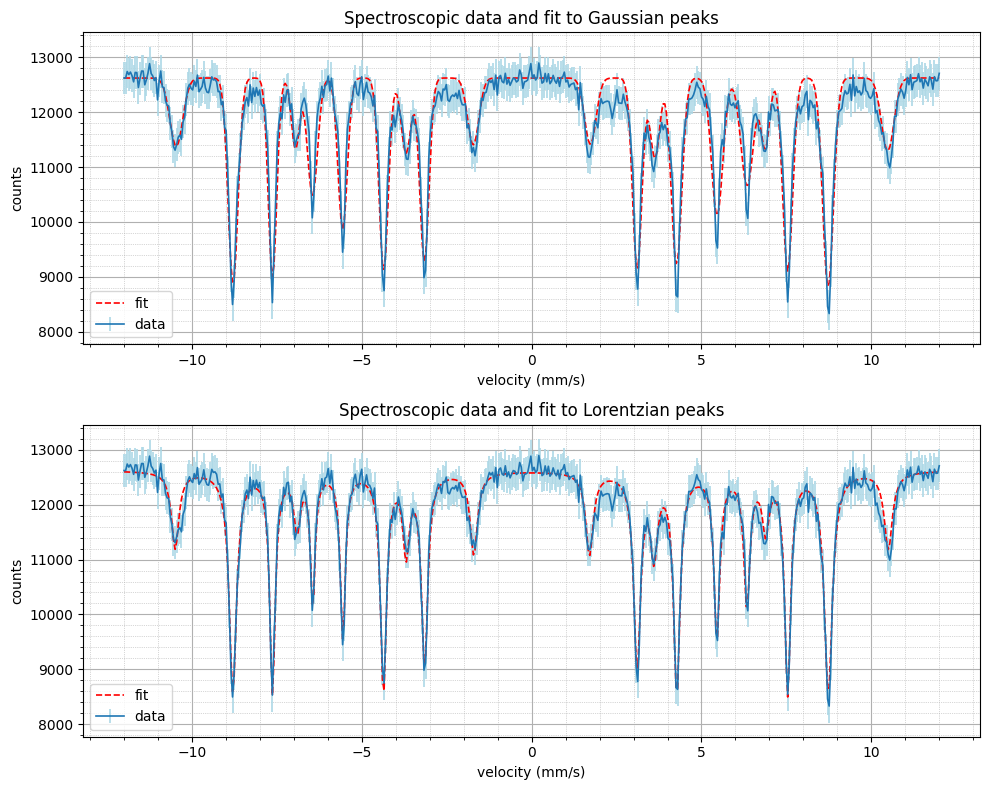

In [17]:
# I plot the results of the steepest descent fits

fig, ax = plt.subplots(figsize=(10,8), nrows=2)

ax[0].errorbar(v, counts, fmt="-", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="data")
ax[0].plot(v, f_g_gauss(v, A_gauss, f_gauss, c_gauss), "r--", linewidth=1.2, label="fit")
ax[0].grid(which='major', linewidth=0.8)
ax[0].grid(which='minor', linestyle=':', linewidth=0.5)
ax[0].minorticks_on()
ax[0].set(xlabel="velocity (mm/s)", ylabel="counts", title="Spectroscopic data and fit to Gaussian peaks")
ax[0].legend()

ax[1].errorbar(v, counts, fmt="-", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="data")
ax[1].plot(v, f_g_lorentz(v, A_lorentz, f_lorentz, c_lorentz), "r--", linewidth=1.2, label="fit")
ax[1].grid(which='major', linewidth=0.8)
ax[1].grid(which='minor', linestyle=':', linewidth=0.5)
ax[1].minorticks_on()
ax[1].set(xlabel="velocity (mm/s)", ylabel="counts", title="Spectroscopic data and fit to Lorentzian peaks")
ax[1].legend()

fig.tight_layout()

### Problem 4

Just by looking at these plots, I can easily see that the Lorentzian peaks reproduce the data better than the Gaussian peaks. The Gaussian peaks have too small tails to fit the data properly, and this results in the peaks falling off too quickly at the base of the peaks. It appears that the algorithm tries to partly compensate for this by making the Gaussian peaks wider. However, this also means that many of the peaks end up being too short compared to the data. On the other hand, the wider-tailed Lorentzian model does not seem to have these problems and therefore reproduces the data well.

In addition to visual inspection of the fitted solution, I can also consider the residuals of the fits in order to evaluate the goodness of fit. The residuals are the difference between the data and the model

$$res = d - g(m).$$

In a good fit, I expect the residuals to be uniformly distributed about zero with most of the residuals being consistent with zero within the uncertainty on the data.

In [18]:
res_gauss = counts - f_g_gauss(v, A_gauss, f_gauss, c_gauss)  # compute residuals of Gaussian fit
res_lorentz = counts - f_g_lorentz(v, A_lorentz, f_lorentz, c_lorentz)  # compute residuals of Lorentzian fit

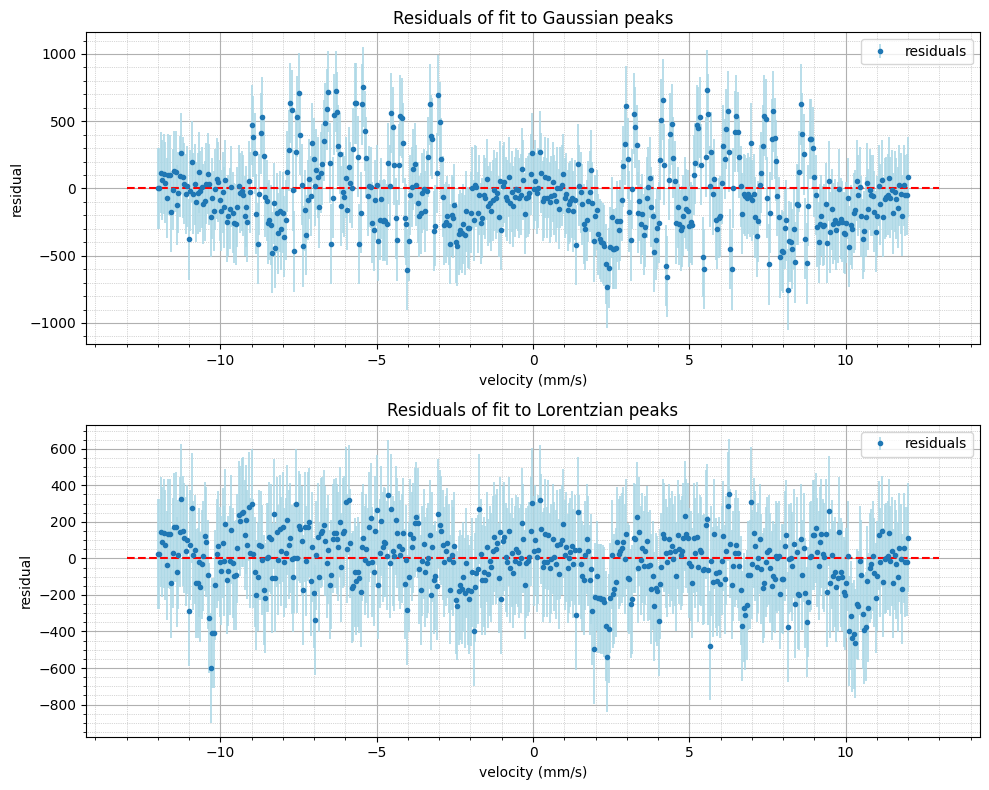

In [19]:
# I plot the residuals for the Gaussian and Lorentzian fits

fig, ax = plt.subplots(figsize=(10,8), nrows=2)

ax[0].errorbar(v, res_gauss, fmt=".", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="residuals")
ax[0].plot((np.min(v)-1, np.max(v)+1), (0, 0), "r--", linewidth=1.5)
ax[0].grid(which='major', linewidth=0.8)
ax[0].grid(which='minor', linestyle=':', linewidth=0.5)
ax[0].minorticks_on()
ax[0].set(xlabel="velocity (mm/s)", ylabel="residual", title="Residuals of fit to Gaussian peaks")
ax[0].legend()

ax[1].errorbar(v, res_lorentz, fmt=".", yerr=dcounts, linewidth=1.2, capsize=0, ecolor="lightblue", label="residuals")
ax[1].plot((np.min(v)-1, np.max(v)+1), (0, 0), "r--", linewidth=1.5)
ax[1].grid(which='major', linewidth=0.8)
ax[1].grid(which='minor', linestyle=':', linewidth=0.5)
ax[1].minorticks_on()
ax[1].set(xlabel="velocity (mm/s)", ylabel="residual", title="Residuals of fit to Lorentzian peaks")
ax[1].legend()

fig.tight_layout()

As expected, the Lorentzian model also seems to fit the data best when considering the residuals as the residuals are somewhat uniformly distributed about zero, and the majority of the residuals are consistent with zero within the data uncertainty.

However, the residuals of the Gaussian fit are not uniformly distributed about zero. Instead, there is a distinct pattern of certain places where the model consistently either overestiemates or underestimates the number of counts. This is also what I expected by looking at the plotted solution alone.